Using device: mps


/var/folders/hh/y2mymwpd0717xb2bwg9nql7c0000gn/T/ipykernel_9050/3196358808.py:135: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f"best_mode

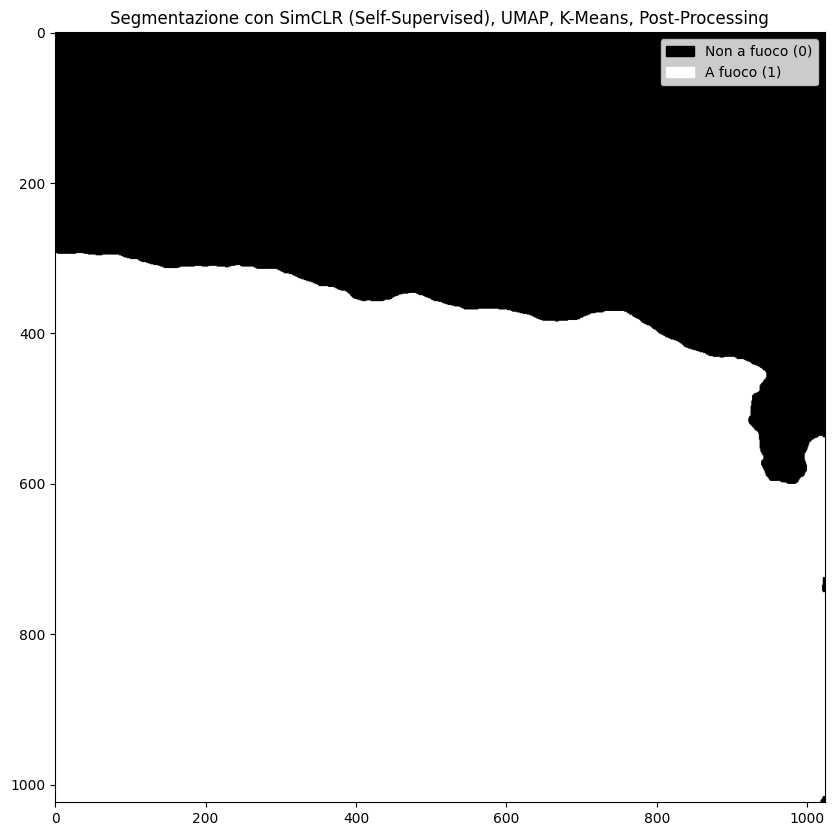

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import tifffile
import numpy as np
import random
from skimage.morphology import closing, opening, square
from scipy.ndimage import median_filter
from sklearn.cluster import KMeans
import umap.umap_ as umap  # Assicurati di aver fatto: pip install umap-learn
import matplotlib.pyplot as plt
from torchvision import transforms
import matplotlib.patches as mpatches


class Patch2DDataset(Dataset):
    def __init__(self, stack_path, patch_size=64, num_patches=5000, use_layer='mean'):
        self.stack = tifffile.imread(stack_path) # (num_layers,H,W)
        self.num_layers, self.H, self.W = self.stack.shape
        
        if use_layer == 'mean':
            self.img = self.stack.mean(axis=0).astype(np.float32)
        elif use_layer == 'middle':
            l = self.num_layers // 2
            self.img = self.stack[l].astype(np.float32)
        else:
            l = int(use_layer)
            self.img = self.stack[l].astype(np.float32)
        
        max_val = self.img.max() if self.img.max()>0 else 1.0
        self.img /= max_val
        
        self.patch_size = patch_size
        self.num_patches = num_patches
        self.coords = []
        for _ in range(num_patches):
            y = np.random.randint(0, self.H - patch_size)
            x = np.random.randint(0, self.W - patch_size)
            self.coords.append((y,x))
        
        self.transform = transforms.Compose([
            transforms.Grayscale(num_output_channels=1),
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomVerticalFlip(p=0.5),
            transforms.ColorJitter(brightness=0.2, contrast=0.2),
            transforms.RandomRotation(degrees=15),
            transforms.ToTensor()
        ])

    def __len__(self):
        return len(self.coords)

    def __getitem__(self, idx):
        y,x = self.coords[idx]
        patch = self.img[y:y+self.patch_size, x:x+self.patch_size]
        patch_pil = transforms.ToPILImage()(patch)
        view1 = self.transform(patch_pil)
        view2 = self.transform(patch_pil)
        return view1, view2, (y,x)

class DeeperEncoder(nn.Module):
    def __init__(self, out_dim=128, dropout_p=0.1):
        super(DeeperEncoder, self).__init__()
        self.net = nn.Sequential(
            nn.Conv2d(1,16,3,2,1),   # 1->16, 64x64->32x32
            nn.LayerNorm([16,32,32]),
            nn.ReLU(),
            nn.Dropout(p=dropout_p),

            nn.Conv2d(16,32,3,2,1),  # 16->32, 32x32->16x16
            nn.LayerNorm([32,16,16]),
            nn.ReLU(),
            nn.Dropout(p=dropout_p),

            nn.Conv2d(32,64,3,2,1),  # 32->64, 16x16->8x8
            nn.LayerNorm([64,8,8]),
            nn.ReLU(),
            nn.Dropout(p=dropout_p),

            nn.Conv2d(64,128,3,2,1), # 64->128, 8x8->4x4
            nn.LayerNorm([128,4,4]),
            nn.ReLU(),
            nn.Dropout(p=dropout_p),

            nn.Conv2d(128,256,3,2,1),# 128->256, 4x4->2x2
            nn.LayerNorm([256,2,2]),
            nn.ReLU(),
            nn.Dropout(p=dropout_p),

            nn.AdaptiveAvgPool2d((1,1))
        )
        self.fc = nn.Linear(256, out_dim)

    def forward(self,x):
        h = self.net(x)
        h = h.view(h.size(0), -1)
        h = self.fc(h)
        return h

class SimCLR(nn.Module):
    def __init__(self, encoder, temperature=0.07):
        super(SimCLR, self).__init__()
        self.encoder = encoder
        self.temperature = temperature

    def forward(self, x1, x2):
        z1 = self.encoder(x1)
        z2 = self.encoder(x2)
        
        z1 = z1 / z1.norm(dim=1, keepdim=True)
        z2 = z2 / z2.norm(dim=1, keepdim=True)
        
        batch_size = z1.size(0)
        sim = torch.matmul(z1, z2.T)
        
        labels = torch.arange(batch_size).to(z1.device)
        
        sim_div = sim / self.temperature
        log_prob = nn.LogSoftmax(dim=1)(sim_div)
        loss = -log_prob[range(batch_size), labels].mean()
        return loss

stack_path = "stacks/stack1.tif"
patch_size = 64
num_patches = 50000

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print("Using device:", device)

encoder = DeeperEncoder(out_dim=128, dropout_p=0.1)  # Usa l'encoder profondo
model = SimCLR(encoder).to(device)

# Carica il miglior modello salvato
model.load_state_dict(torch.load(f"best_model_SimCLR_deep5_{patch_size}.pth"))
model.eval()

dataset_for_cluster = Patch2DDataset(stack_path, patch_size=patch_size, num_patches=num_patches, use_layer='mean')
dataloader_for_cluster = DataLoader(dataset_for_cluster, batch_size=64, shuffle=False)

features = []
coords = dataset_for_cluster.coords
with torch.no_grad():
    for (view1, view2, c) in dataloader_for_cluster:
        view1 = view1.to(device)
        z = model.encoder(view1)
        z = z.cpu().numpy()
        features.append(z)
features = np.concatenate(features, axis=0)

reducer = umap.UMAP(n_components=2, random_state=42)
umap_features = reducer.fit_transform(features)

kmeans = KMeans(n_clusters=2, random_state=42)
labels = kmeans.fit_predict(umap_features)

H, W = dataset_for_cluster.H, dataset_for_cluster.W
patch_size = dataset_for_cluster.patch_size
prob_map = np.zeros((H,W), dtype=np.float32)
count_map = np.zeros((H,W), dtype=np.float32)

for i, (y,x) in enumerate(coords):
    val = float(labels[i])
    prob_map[y:y+patch_size, x:x+patch_size] += val
    count_map[y:y+patch_size, x:x+patch_size] += 1.0

mask = np.zeros((H,W), dtype=np.float32)
valid = (count_map>0)
mask[valid] = prob_map[valid]/count_map[valid]
binary_map = (mask>0.5).astype(np.uint8)

binary_map = median_filter(binary_map, size=5)
binary_map = opening(binary_map, square(5))
binary_map = closing(binary_map, square(5))

plt.figure(figsize=(10,10))
plt.imshow(binary_map, cmap='gray')
plt.title("Segmentazione con SimCLR (Self-Supervised), UMAP, K-Means, Post-Processing")

# Crea i patch per la legenda
non_a_fuoco_patch = mpatches.Patch(color='black', label='Non a fuoco (0)')
a_fuoco_patch = mpatches.Patch(color='white', label='A fuoco (1)')

# Aggiungi la legenda alla stessa figura prima di chiamare plt.show()
plt.legend(handles=[non_a_fuoco_patch, a_fuoco_patch], loc='upper right')

# Ora mostra l'immagine una sola volta
plt.show()